In [5]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
df = pd.read_csv('credit_card_default_analysis.csv')

# Problem 1

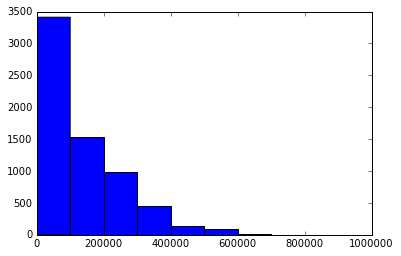

In [7]:
A = plt.hist(df[df.default == 1].LIMIT_BAL.as_matrix(), range=(0, 1e6))
plt.show()

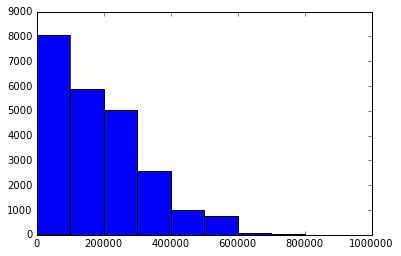

In [8]:
B = plt.hist(df[df.default == 0].LIMIT_BAL.as_matrix(), range=(0, 1e6))
plt.show()

На глаз оба распределения похожи на пуассоновские, что и разумно, потому что исследуемая переменная по свойствам похожа на счётчик.

Проверим, равны ли медианные значения кредитных лимитов. Нулоева гипотеза - медианы равны. Проверять будем бутстрапированием, против двусторонней альтернативы.

In [9]:
lim_succ = df[df.default == 1].LIMIT_BAL.as_matrix()
lim_fail = df[df.default == 0].LIMIT_BAL.as_matrix()

In [10]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

def conf_int(data,stat_func,alpha=0.05,n_samples=1000):
    scores = [stat_func(sample) for sample in get_bootstrap_samples(data,n_samples)]
    return stat_intervals(scores, alpha)

def diff_conf_int(a,b,stat_func,alpha=0.05,n_samples=1000):
    scores_a = [stat_func(sample) for sample in get_bootstrap_samples(a,n_samples)]
    scores_b = [stat_func(sample) for sample in get_bootstrap_samples(b,n_samples)]
    delta_scores = [x[0] - x[1] for x in zip(scores_a,scores_b)]
    return stat_intervals(delta_scores, alpha)

In [11]:
diff_conf_int(lim_succ, lim_fail, np.median)

array([-70000., -60000.])

In [12]:
conf_int(lim_succ, np.median)

array([ 80000.,  90000.])

In [13]:
conf_int(lim_fail, np.median)

array([ 150000.,  150000.])

Итак, на уровне значимости 0.05 гипотеза о равенстве медиан уверенно отвергается. Кроме того, средние значения, как видно по 95%-ным интервалам, *существенно* отличаются. Интерпретировать практическую значимость результата можно так: небольшие кредиты (не больше 100 000 рублей или чуть больше), как правило, возвращаются успешнее, чем большие (150 000 и больше).

Теперь проверим эту гипотезу непараметрическим критерием (ранговый критерий Манна-Уитни). Здесь нулевая гипотеза - $P(X_{succ} < X_{fail}) = P(X_{succ} > X_{fail})$

In [14]:
scipy.stats.mannwhitneyu(lim_succ, lim_fail)

MannwhitneyuResult(statistic=59257217.5, pvalue=3.4348973226457305e-189)

Итак, нулевая гипотеза и здесь отвергается.

# Problem 2

In [15]:
sex_succ = df[df.default == 1].SEX.as_matrix()
sex_fail = df[df.default == 0].SEX.as_matrix()

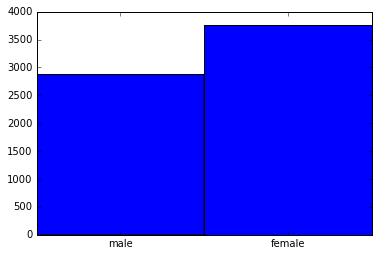

In [16]:
fig, ax = plt.subplots()
ax.hist(sex_succ, bins=2, range=(1, 3))
ax.set_xticks([1.5, 2.5])
ax.set_xticklabels(['male', 'female'])
plt.show()

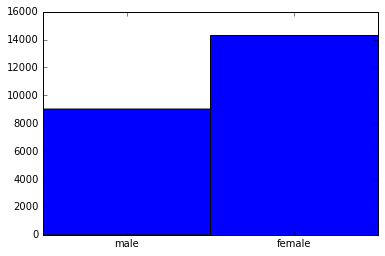

In [17]:
fig, ax = plt.subplots()
ax.hist(sex_fail, bins=2, range=(1, 3))
ax.set_xticks([1.5, 2.5])
ax.set_xticklabels(['male', 'female'])
plt.show()

Как видим из гистограмы, женщины возвращают ненамного больше кредитов (3500 против 2500), а вот *не* возвращают заметно больше (14000 против ~9000).

Проверим это статистическим критерием для доли. Нулевая гипотеза - доли в выборках равны. Проверяем против двусторонней альтернативы. Статистический критерий - Z-критерий для разности долей в несвязанных выборках.

In [18]:
def proportions_diff_confint(A, B, alpha=0.05):
    z_score = scipy.stats.norm.ppf(1 - alpha / 2)
    n1, n2 = A.shape[0], B.shape[0]
    p1 = (A == 1).sum() / (n1)
    p2 = (B == 1).sum() / (n2)
    point_est = p1 - p2
    delta = z_score * np.sqrt(p1 * (1-p1) / n1 + p2 * (1-p2) / n2)
    return (point_est - delta, point_est + delta)

In [19]:
proportions_diff_confint(sex_succ, sex_fail)

(0.0, 0.0)

In [20]:
def proportions_diff_pvalue(A, B):
    n1, n2 = A.shape[0], B.shape[0]
    p1 = (A == 1).sum() / (n1)
    p2 = (B == 1).sum() / (n2)
    point_est = p1 - p2
    delta = np.sqrt(p1 * (1-p1) / n1 + p2 * (1-p2) / n2)
    z_score = point_est / delta
    return 2 * (1 - scipy.stats.norm.cdf(z_score))

In [21]:
proportions_diff_pvalue(sex_succ, sex_fail)

nan

Итак, гипотеза о равенстве долей отвергается на уровне значимости 0.05 (достигаемый уровень значимости крайне мал). Величина эффекта здесь не настолько велика - порядка 3-6%.

# Problem 3

In [22]:
edu_succ = df[df.default == 1].EDUCATION.as_matrix()
edu_fail = df[df.default == 0].EDUCATION.as_matrix()

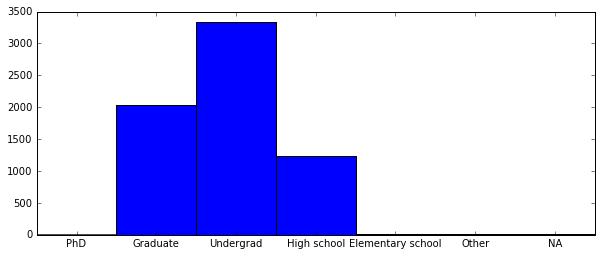

In [23]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
ax.hist(edu_succ, bins=7, range=(0, 7))
ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
ax.set_xticklabels(['PhD', 'Graduate', 'Undergrad', 'High school', 'Elementary school', 'Other', 'NA'])
plt.show()

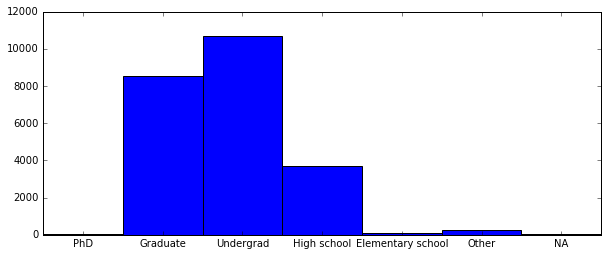

In [24]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
ax.hist(edu_fail, bins=7, range=(0, 7))
ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
ax.set_xticklabels(['PhD', 'Graduate', 'Undergrad', 'High school', 'Elementary school', 'Other', 'NA'])
plt.show()

Проверим предположение о независимости полученного образования и невозврата кредита. Нулевая гипотеза: эти две величины независимы. Проверяем против альтернативы связанности критерием $\chi^2$.

In [25]:
# Проверка условий применения chi^2.
cnt_table = list()
for cat in np.unique(df.EDUCATION):
    total = len(df[df.EDUCATION == cat].default)
    def_cnt = np.sum(df[df.EDUCATION == cat].default)
    cnt_table.append([def_cnt, total - def_cnt])
    
cnt_ip = np.sum(cnt_table, axis=1)
cnt_jp = np.sum(cnt_table, axis=0)
n = np.sum(cnt_table, axis=None)

small_cells = (
len(
    list(
        filter(
            lambda x: x < 5,
            [cnt_ip[i]*cnt_jp[j]/n for j in range(len(cnt_jp)) for i in range(len(cnt_ip))]
        )
    )
)
) / (len(cnt_ip) * len(cnt_jp))
print('{:.0f}%'.format(small_cells*100))

0%


Итак, условия применимости критерия $\chi^2$ выполнены, и теперь мы можем применить его.

In [26]:
A, B = np.bincount(edu_succ), np.bincount(edu_fail)
B = B / B.sum() * A.sum()
print(scipy.stats.chisquare(A, B))

Power_divergenceResult(statistic=nan, pvalue=nan)


Итак, мы можем уверенно отклонить нулевую гипотезу  на уровне значимости 0.05.

In [27]:
A, B = np.bincount(edu_succ), np.bincount(edu_fail)
cats = ['PhD', 'Grad', 'Undergrad', 'High school', 'Elem school', 'Other', 'NA']
for cat, freq in sorted(list(zip(cats, A / B)), key=lambda x: x[1]):
    print('{} -> {}'.format(cat, freq))

PhD -> 0
Grad -> 0
Undergrad -> 0
High school -> 0
Elem school -> 0
Other -> 0
NA -> 0


Как видно, доктора - самые надёжные люди в смысле возврата кредита, а студенты/школьники - самые ненадёжные.

# Problem 4

In [28]:
mar_succ = df[df.default == 1].MARRIAGE.as_matrix()
mar_fail = df[df.default == 0].MARRIAGE.as_matrix()

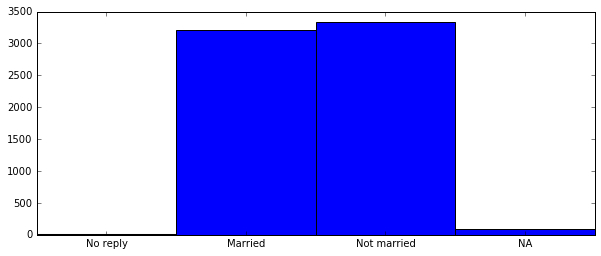

In [29]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
ax.hist(mar_succ, bins=4, range=(0, 4))
ax.set_xticks([0.5, 1.5, 2.5, 3.5])
ax.set_xticklabels(['No reply', 'Married', 'Not married', 'NA'])
plt.show()

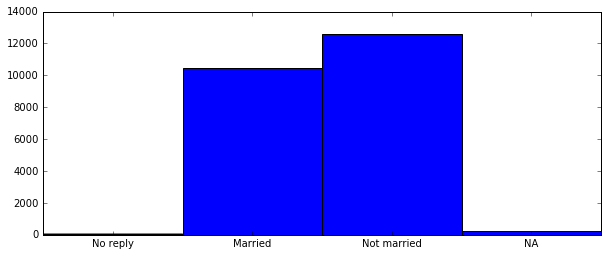

In [30]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
ax.hist(mar_fail, bins=4, range=(0, 4))
ax.set_xticks([0.5, 1.5, 2.5, 3.5])
ax.set_xticklabels(['No reply', 'Married', 'Not married', 'NA'])
plt.show()

Проверим предположение о независимости семейного положения и невозврата кредита. Нулевая гипотеза: эти две величины независимы. Проверяем против альтернативы связанности критерием $\chi^2$.

Но сначала проверим условия его применимости.

In [31]:
# Проверка условий применения chi^2.
cnt_table = list()
for cat in np.unique(df.MARRIAGE):
    total = len(df[df.MARRIAGE == cat].default)
    def_cnt = np.sum(df[df.MARRIAGE == cat].default)
    cnt_table.append([def_cnt, total - def_cnt])
    
cnt_ip = np.sum(cnt_table, axis=1)
cnt_jp = np.sum(cnt_table, axis=0)
n = np.sum(cnt_table, axis=None)

small_cells = (
len(
    list(
        filter(
            lambda x: x < 5,
            [cnt_ip[i]*cnt_jp[j]/n for j in range(len(cnt_jp)) for i in range(len(cnt_ip))]
        )
    )
)
) / (len(cnt_ip) * len(cnt_jp))
print('{:.0f}%'.format(small_cells*100))

0%


In [32]:
A, B = np.bincount(mar_succ), np.bincount(mar_fail)
B = B / B.sum() * A.sum()
print(scipy.stats.chisquare(A, B))
print('Cramer\'s V = {}'.format(np.sqrt(scipy.stats.chisquare(A, B).statistic / len(df.EDUCATION))))

Power_divergenceResult(statistic=inf, pvalue=0.0)
Cramer's V = inf


Гипотезу о независимости брачного статуса и возврата кредита мы можем отвергнуть. Коэффициент Крамера, впрочем, показыввает, что эффект незначителен.

# Problem 5

In [33]:
age_succ = df[df.default == 1].AGE.as_matrix()
age_fail = df[df.default == 0].AGE.as_matrix()

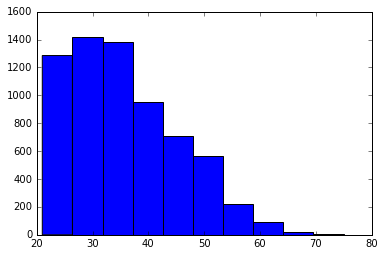

In [34]:
plt.hist(age_succ)
plt.show()

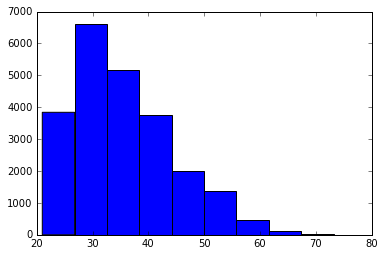

In [35]:
plt.hist(age_fail)
plt.show()

Проверим гипотезу о равенстве медианных значений возрастов в группах. Нулевая гипотеза - медианы равны. Проверяем против двусторонней альтернативы на уровне значимости 0.05.

In [36]:
diff_conf_int(age_succ, age_fail, np.median)

array([ 0.,  1.])

Интервал содержит 0, а потому отвергнуть нулевую гипотезу мы не можем. Воспользуемся перестановочным критерием. Нулевая гипотеза - распределения одинаковы. Альтернатива - одно из распределений "сдвинуто" относительно другого.

In [37]:
import itertools

np.random.seed(1337)

def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n)))
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean()
             for i in indices]
    return distr

In [38]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [39]:
permutation_test(age_succ, age_fail, max_permutations=5000)

0.0144

А вот перестановочный тест позволяет отвергнуть нулевую гипотезу на уровне значимости 0.05. Практически же, как видно из построения доверительного интервала, это различие не значимо.